In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from metadPy.sdt import rates, dprime, criterion
from metadPy.utils import trials2counts, discreteRatings
from scipy.stats import norm
import seaborn as sns
import numpy as np
import pingouin as pg
from systole.detection import oxi_peaks, rr_artefacts

sns.set_context('paper')

Import summary statistics from behavioral data

In [2]:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
group_df = pd.read_csv(path + '/data/behavior.txt')
group_df = group_df[group_df.Session == 'Del1']

# Psychophysic parameters of the task

## Psychometric functions parameters

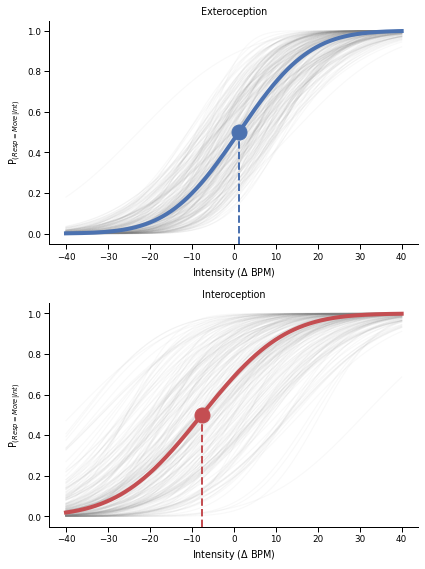

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
for i, modality, col in zip((0, 1), ['Extero', 'Intero'], ['#4c72b0', '#c44e52']):
    threshold, slope = [], []
    for subject in group_df.Subject.unique():
        threshold.append(group_df.Threshold[(group_df.Modality == modality) & (group_df.Subject == subject)].values)
        slope.append(group_df.Slope[(group_df.Modality == modality) & (group_df.Subject == subject)].values)

        # Plot Psi estimate of psychometric function
        axs[i].plot(np.linspace(-40, 40, 500), 
                (norm.cdf(np.linspace(-40, 40, 500), loc=threshold[-1], scale=slope[-1])),
                '-', color='gray', alpha=.05)
        axs[i].set_ylabel('P$_{(Resp = More|Int)}$')
        axs[i].set_xlabel('Intensity ($\Delta$ BPM)')
        axs[i].set_title(f'{modality}ception')
    axs[i].plot(np.linspace(-40, 40, 500), 
            (norm.cdf(np.linspace(-40, 40, 500), loc=np.array([threshold]).mean(), scale=np.array([slope]).mean())),
            '-', color=col, linewidth=4)
    axs[i].plot(np.array([threshold]).mean(), 0.5, 'o', color=col, markersize=15)
    axs[i].axvline(x=np.array([threshold]).mean(), ymin=0, ymax=0.5, linestyle='--', color=col, linewidth=2)
plt.tight_layout()
sns.despine()
plt.savefig(path + '/figures/Fig2_psychometric.svg', dpi=600)

## Threshold and slope parameters

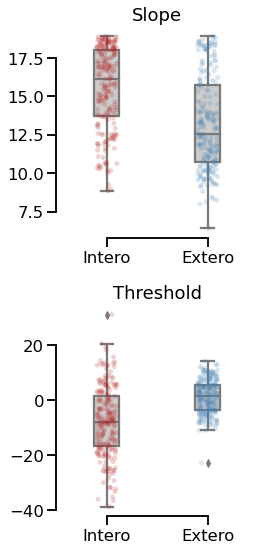

In [32]:
sns.set_context('talk')
fig, axs = plt.subplots(2, 1, figsize=(4, 8))
axs = axs.ravel()
for i, metric in enumerate(['Slope', 'Threshold']):
    sns.boxplot(data=group_df, x='Modality', y=metric, ax=axs[i], color=".8", width=.25)
    sns.stripplot(data=group_df, x='Modality', y=metric, ax=axs[i], palette=['firebrick', 'steelblue'], alpha=.2, dodge=.4)
    axs[i].set_title(metric)
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
plt.tight_layout()
sns.despine(trim=10)
plt.savefig(path + '/figures/Fig2_threshold_slope.svg', dpi=600)

In [5]:
pg.pairwise_ttests(data=group_df, dv='Threshold', within='Modality')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,Modality,Intero,Extero,True,True,-10.086845,212.0,two-sided,8.574371e-20,5.365e+16,-0.897931


In [6]:
pg.pairwise_ttests(data=group_df, dv='Slope', within='Modality')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,Modality,Intero,Extero,True,True,8.29577,212.0,two-sided,1.246912e-14,4.74e+11,0.825769


## Post-hoc psychometric function fitting

In [3]:
import bayesfit as bf

In [4]:
merged_df = pd.read_csv(path + '/data/merged.txt')
merged_df = merged_df[merged_df.Session=='Del1']

In [5]:
def to_bayesfit(df):
    """Trials level data formatted for BayesFit"""
    bayes_df = pd.DataFrame([])
    for intensity in this_df.Alpha.unique():
        nRatings = len(this_df[this_df.Alpha == intensity])
        nCorrects = len(this_df[(this_df.Alpha == intensity) & (this_df.ResponseCorrect == 1)])
        bayes_df = bayes_df.append(pd.DataFrame({'Intensity': [intensity], 'nCorrects': [int(nCorrects)], 'nRatings': [int(nRatings)]}))
    return bayes_df.to_numpy()

In [6]:
for sub in merged_df.Subject.unique():
    for mod in ['Intero', 'Extero']:
        this_df = merged_df[(merged_df.Subject==sub) & (merged_df.Modality==mod)]
        this_df = this_df[~this_df.ResponseCorrect.isnull()]
        np_bayes = to_bayesfit(this_df)

In [78]:
# Define cumulative normal function to use as sigmoidal function
sigmoid_type = 'norm'

# List of logical arguments which correspond to: scale, slope, gamma, lambda
param_free = [True, True, False, False]

# Define priors for scale and slope parameters (here mu, and sigma)
priors = ['Norm(0,10)', 'Norm(20,2)', None, None]

# Fit model
metrics, options = bf.fitmodel(np_bayes, param_free=param_free, priors=priors, sigmoid_type=sigmoid_type, nafc=1, threshold=.5)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\bayesfit\extractMetrics.py:92: RuntimeWarning: divide by zero encountered in log
  Deviance = 2*np.sum(n*y*np.log(y/p) + n*(1-y)*np.log((1-y)/(1-p)))
C:\ProgramData\Anaconda3\lib\site-packages\bayesfit\extractMetrics.py:92: RuntimeWarning: invalid value encountered in multiply
  Deviance = 2*np.sum(n*y*np.log(y/p) + n*(1-y)*np.log((1-y)/(1-p)))
C:\ProgramData\Anaconda3\lib\site-packages\bayesfit\extractMetrics.py:92: RuntimeWarning: divide by zero encountered in true_divide
  Deviance = 2*np.sum(n*y*np.log(y/p) + n*(1-y)*np.log((1-y)/(1-p)))
C:\ProgramData\Anaconda3\lib\site-packages\bayesfit\extractMetrics.py:92: RuntimeWarning: invalid value encountered in true_divide
  Deviance = 2*np.sum(n*y*np.log(y/p) + n*(1-y)*np.log((1-y)/(1-p)))
C:\ProgramData\Anaconda3\lib\site-pack

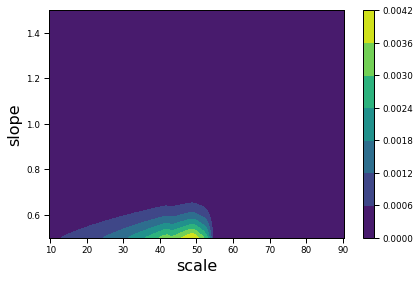

In [79]:
bf.plot_posterior(metrics)

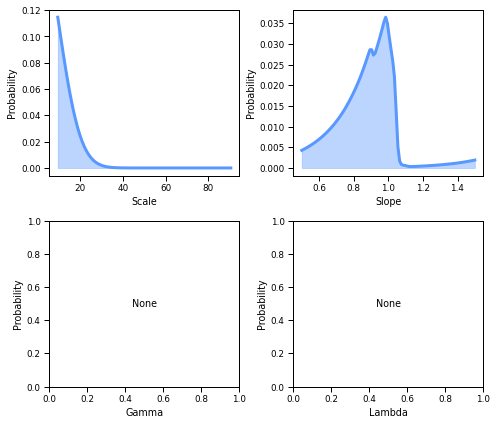

In [80]:
bf.plot_marginals(metrics)

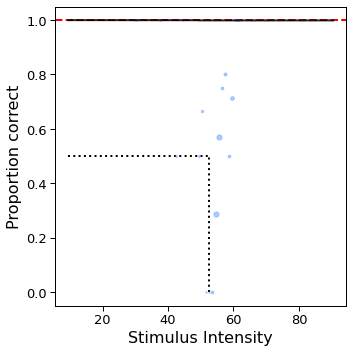

In [81]:
bf.plot_psyfcn(np_bayes, options, metrics)

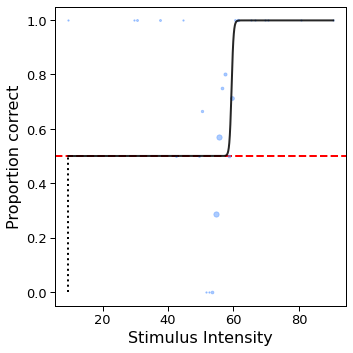

In [95]:
bf.plot_psyfcn(np_bayes, options, metrics)